## NLP stuff with Spotify User Reviews

Here we load, preprocess and explore Spotify user reviews to learn NLP preprocessing methods and gain first insights into the dataset.

In [1]:
## Setting to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
## Import general libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
## Read data and copy
spotify = pd.read_csv("../data/raw/spotify_review_kaggle.csv")
data_in = spotify.copy()

In [4]:
## Check Data
data_in.head(10)

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
5,2022-07-09 13:20:20,The player controls sometimes disappear for no...,3,7,NaN
6,2022-07-09 13:19:21,I love the selection and the lyrics are provid...,5,0,NaN
7,2022-07-09 13:17:22,Still extremely slow when changing storage to ...,3,16,NaN
8,2022-07-09 13:16:49,It's a great app and the best mp3 music app I ...,5,0,NaN
9,2022-07-09 13:11:32,"I'm deleting this app, for the following reaso...",1,318,NaN


In [5]:
## Sample some reviews
data_in["Review"].sample(10)

5756     It asks me if i want to watch a short add for ...
57347    Great app! Always updating UI/UX features. Wit...
35930    Hello, my player disappears when I exit the ap...
31003    The bar at the bottom doesn't always display t...
11228    We want only three bottom buttons > home searc...
35440    Ever since the new update playing over Bluetoo...
11299    The app is too much good for Song😊😊😊😊😚😚😚❤️❤️❤️...
49413    Keeps cutting off and on muting songs,I have u...
49787    I love it I just really love it! It has my fav...
26512    There is a bad ad to song ratio. This ratio is...
Name: Review, dtype: object

In [6]:
## Data info
data_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


In [7]:
## Remove duplicates
## Since we are changing the raw input data, let's change the name to data
print("Before dropping duplicates: ", len(data_in))
data = data_in.drop_duplicates(subset="Review")
print("After dropping duplicates: ", len(data))


Before dropping duplicates:  61594
After dropping duplicates:  61356


In [8]:
## Drop unused cols
data.drop(["Time_submitted", "Total_thumbsup", "Reply"], axis=1, inplace=True)
data.head(5)

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1


In [9]:
## Ad col for reviews length of review in words
data["Length"] = data["Review"].str.split(" ").str.len()
data.head()

,Review,Rating,Length
0,"Great music service, the audio is high quality...",5,21
1,Please ignore previous negative rating. This a...,5,15
2,"This pop-up ""Get the best Spotify experience o...",4,19
3,Really buggy and terrible to use as of recently,1,9
4,Dear Spotify why do I get songs that I didn't ...,1,21


In [10]:
## Check shortest reviews
data.sort_values("Length").head(10)

,Review,Rating,Length
24628,Easy-to-use software,5,2
30670,"Powerful,Spirit-touching songs",5,2
27164,Best music service,5,3
4562,Always interrupts ads,1,3
4569,To many advertisement!!!,1,3
9923,Too much ads.,1,3
4572,Love no ads!,5,3
33635,Brilliant music app,5,3
9938,Full of adds,1,3
13112,Great and dynamic,5,3


In [11]:
## Check longest reviews
data.sort_values("Length").tail(10)

,Review,Rating,Length
61568,I have been using Spotify premium. Biggest dis...,3,150
24495,"SPOTIFY IS TERRIBLE! Before podcasts, Spotify ...",1,157
23836,"Works fine for my phone, however for the past ...",2,159
27916,Edit - came back to remove a star. Jesus cance...,2,165
19664,Spotify is a great way to listen to music alth...,4,175
40973,Although I like Spotify and I use it a lot (an...,3,185
26055,I am giving the 3 month free trial a go and so...,4,219
46004,"I am using Spotify soon for a year, before I u...",4,222
20489,"Attention Android Users: unfortunately, there ...",1,279
40566,"I very rarely leave reviews and if I do, they'...",1,699


<Figure size 1200x600 with 0 Axes>

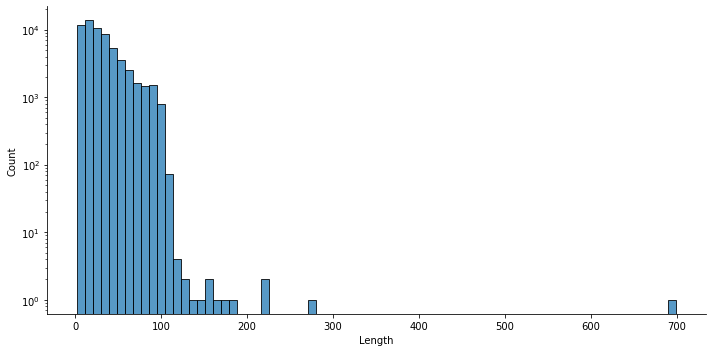

In [12]:
## Plot Review Length as hist
plt.figure(figsize=(4,2), dpi=300)
ax = sns.displot(data["Length"], kind="hist", fill=True, aspect=2, bins=75, log=True);

In [13]:
data["Length"].describe()

count    61356.000000
mean        30.991786
std         22.724590
min          2.000000
25%         14.000000
50%         25.000000
75%         42.000000
max        699.000000
Name: Length, dtype: float64

As we can see, most reviews are no longer than around 120 words; as a next step, we could remove all reviews with more than 150 words.

In [14]:
## Drop long reviews
data = data[data.Length < 150]
print("Number of reviews after trimming: ", len(data))

Number of reviews after trimming:  61346


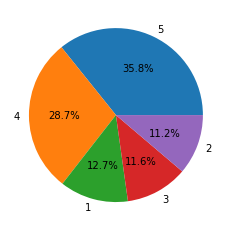

In [15]:
## Visualize distribution of ratings
## EDIT LATER
plt.pie(data['Rating'].value_counts(), labels=data['Rating'].unique(), autopct='%1.1f%%')
plt.show()

In [16]:
## Code sentiment from rating (1 or 2 == bad, 3 == neutral, 4 or 5 == good)
def get_sentiment(rating):
    if rating == 1 or rating == 2:
        return "negative"
    if rating == 3:
        return "neutral"
    if rating == 4 or rating == 5:
        return "positive"

In [17]:
data["Sentiment"] = data["Rating"].apply(get_sentiment)

data.head(10)

,Review,Rating,Length,Sentiment
0,"Great music service, the audio is high quality...",5,21,positive
1,Please ignore previous negative rating. This a...,5,15,positive
2,"This pop-up ""Get the best Spotify experience o...",4,19,positive
3,Really buggy and terrible to use as of recently,1,9,negative
4,Dear Spotify why do I get songs that I didn't ...,1,21,negative
5,The player controls sometimes disappear for no...,3,19,neutral
6,I love the selection and the lyrics are provid...,5,15,positive
7,Still extremely slow when changing storage to ...,3,62,neutral
8,It's a great app and the best mp3 music app I ...,5,43,positive
9,"I'm deleting this app, for the following reaso...",1,80,negative


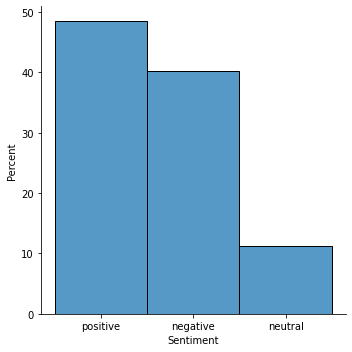

In [18]:
## Plot sentiment distribution (e.g. sns.histplot)
ax = sns.displot(data=data, x='Sentiment', stat='percent');

In [19]:
## Look for relationship between length and sentiment
data[["Length","Sentiment"]].groupby("Sentiment").describe()

Length                                                    
             count       mean        std  min   25%   50%   75%    max
Sentiment                                                             
negative   24713.0  37.777202  23.415594  3.0  20.0  32.0  50.0  137.0
neutral     6874.0  36.963777  23.270817  3.0  19.0  32.0  49.0  111.0
positive   29759.0  23.906885  19.092666  2.0  10.0  18.0  31.0  113.0

### Preprocessing

In [20]:
## Import special libraries
import emojis
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize as tokenizer

In [21]:
## Get NLTK english stopwords
our_stopwords = set(stopwords.words('english'))

In [22]:
#nltk.download()

In [23]:
## TEXT PREPROCESSING
## 1. Lowercase
## 2. Remove Punct
## 3. Tokenize with standard tokenizer
## 4. Remove Stopwords

## TEXT TRANSFORMATIONS
## 6. Bag of Word Model
## 7. Term-Frequency Inverse-Document-Frequency (TF-IDF)
## 8. Delete highly frequent tokens (tokens that are in 90% of docs)
## 9. Delete very low frequent tokens (tokens that are in less than 5% of docs)

In [31]:
## 1. Lowercase all words
data["Review"] = data["Review"].str.lower()
data.head(10)

,Review,Rating,Length,Sentiment
0,"great music service, the audio is high quality...",5,21,positive
1,please ignore previous negative rating. this a...,5,15,positive
2,"this pop-up ""get the best spotify experience o...",4,19,positive
3,really buggy and terrible to use as of recently,1,9,negative
4,dear spotify why do i get songs that i didn't ...,1,21,negative
5,the player controls sometimes disappear for no...,3,19,neutral
6,i love the selection and the lyrics are provid...,5,15,positive
7,still extremely slow when changing storage to ...,3,62,neutral
8,it's a great app and the best mp3 music app i ...,5,43,positive
9,"i'm deleting this app, for the following reaso...",1,80,negative


In [35]:
data["Review"].sample(20)

53063    very bad performance......it was a good app un...
44525    i have being using spotify for awhile now its ...
59225    unusable app. it stopped working on my moto g9...
45531    i love it it's the best it's way better than p...
16870    why is it so slow? even with fast internet it ...
45474    absolutely great app! just wish it would tell ...
3945     i love my music and especially morbid crime po...
34455    honestly i never rate apps this high....but mu...
60156    when it works its very convenient, but it has ...
26303    i'm new with spotify but i love getting very m...
21454    i wish spotify stations was still available it...
20853    the app is superb but the problem is that song...
19359    when i search for a specific song it plays som...
15527    can't believe i'm writing this but spotify has...
29074    ads are annoying but other than that it's great 👍
217      i use this app multiple times daily. this migh...
36365    after last update something went wrong! i can'.

In [32]:
## 2./3. Tokenize Remove Punctuation
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [38]:
tokens = data["Review"].apply(tokenizer.tokenize)

In [81]:
tokens.sample(20)

15926    [cant, access, the, offline, content, i, downl...
36777    [i, m, having, the, same, issue, laura, b, dis...
18352                                [awesome, music, app]
31527    [after, last, update, something, happened, wit...
24847    [hey, can, you, add, something, like, a, butto...
3320     [trash, login, system, whenever, i, try, loggi...
38787    [this, is, a, really, fun, app, to, listen, bu...
29805    [there, are, some, significant, usability, iss...
38963    [the, app, is, good, the, design, is, cool, th...
57899    [they, don, t, care, about, their, community, ...
32551    [music, completely, stops, and, to, get, anyth...
17281    [app, is, crashing, whenever, i, tried, to, pl...
51644    [amazing, it, helps, me, to, listen, to, song,...
49596    [i, love, it, has, all, different, songs, and,...
19740    [i, cannot, share, the, songs, to, connected, ...
19911    [it, really, good, the, best, music, app, i, h...
9109     [i, ve, been, using, a, 6gb, ram, phone, but, .

In [94]:
data["Tokens"] = tokens

In [95]:
data.head()

,Review,Rating,Length,Sentiment,Tokens
0,"great music service, the audio is high quality...",5,21,positive,"[great, music, service, the, audio, is, high, ..."
1,please ignore previous negative rating. this a...,5,15,positive,"[please, ignore, previous, negative, rating, t..."
2,"this pop-up ""get the best spotify experience o...",4,19,positive,"[this, pop, up, get, the, best, spotify, exper..."
3,really buggy and terrible to use as of recently,1,9,negative,"[really, buggy, and, terrible, to, use, as, of..."
4,dear spotify why do i get songs that i didn't ...,1,21,negative,"[dear, spotify, why, do, i, get, songs, that, ..."


In [99]:
## 4. Remove Stopwords
data['Tokens_wo_stopwords'] = data['Tokens'].apply(lambda x: [word for word in x if word not in (our_stopwords)])
data.head()

,Review,Rating,Length,Sentiment,Tokens,Tokens_wo_stopwords
0,"great music service, the audio is high quality...",5,21,positive,"[great, music, service, the, audio, is, high, ...","[great, music, service, audio, high, quality, ..."
1,please ignore previous negative rating. this a...,5,15,positive,"[please, ignore, previous, negative, rating, t...","[please, ignore, previous, negative, rating, a..."
2,"this pop-up ""get the best spotify experience o...",4,19,positive,"[this, pop, up, get, the, best, spotify, exper...","[pop, get, best, spotify, experience, android,..."
3,really buggy and terrible to use as of recently,1,9,negative,"[really, buggy, and, terrible, to, use, as, of...","[really, buggy, terrible, use, recently]"
4,dear spotify why do i get songs that i didn't ...,1,21,negative,"[dear, spotify, why, do, i, get, songs, that, ...","[dear, spotify, get, songs, put, playlist, shu..."


In [100]:
## Split data into train, dev, and test set
from sklearn.model_selection import train_test_split


In [101]:
X = data["Tokens_wo_stopwords"]
y = data["Sentiment"]

In [107]:
print(X.shape, y.shape)

(61346,) (61346,)


In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36807,) (24539,) (36807,) (24539,)


In [111]:
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify = y_test, random_state=42)
print(X_dev.shape, X_test.shape, y_dev.shape, y_test.shape)

(12269,) (12270,) (12269,) (12270,)


In [112]:
## TRANSFORMATIONS
## 5. Counts
from sklearn.feature_extraction.text import CountVectorizer

In [117]:
def dummy(doc):
    return doc
count_vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
## Only fit on training set
count_vectorizer.fit(X_train)
X_train_counts = count_vectorizer.transform(X_train)
X_dev_counts = count_vectorizer.transform(X_dev)


In [126]:
pd.DataFrame(X_dev_counts).head()

,0
0,"(0, 272)\t1\n (0, 791)\t1\n (0, 4217)\t1\n..."
1,"(0, 742)\t1\n (0, 1215)\t1\n (0, 1440)\t4\..."
2,"(0, 1440)\t1\n (0, 2671)\t1\n (0, 6312)\t1..."
3,"(0, 918)\t1\n (0, 1440)\t1\n (0, 2208)\t1\..."
4,"(0, 5701)\t1\n (0, 7119)\t1\n (0, 8134)\t1..."


In [127]:
## TRANSFORMATIONS
## 5. TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

In [138]:
def dummy(doc):
    return doc
tfidf_vectorizer = TfidfVectorizer(tokenizer=dummy, preprocessor=dummy)
## Only fit on training set
tfidf_vectorizer.fit(X_train)
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_dev_tfidf = tfidf_vectorizer.transform(X_dev)

In [140]:
pd.DataFrame(X_dev_tfidf).sample(20)

,0
11808,"(0, 17744)\t0.15459661300478195\n (0, 17132..."
1942,"(0, 16466)\t0.4813702329529971\n (0, 11803)..."
10468,"(0, 10441)\t0.2560491984163503\n (0, 9681)\..."
5994,"(0, 16557)\t0.5312372373513079\n (0, 16495)..."
695,"(0, 15382)\t0.27369468250331314\n (0, 15214..."
323,"(0, 17687)\t0.2986456526286992\n (0, 15954)..."
6683,"(0, 17770)\t0.24782501082709243\n (0, 15957..."
6620,"(0, 17806)\t0.1533990552628528\n (0, 17049)..."
10454,"(0, 15876)\t0.3509007706817332\n (0, 14758)..."
798,"(0, 17966)\t0.1894357119182449\n (0, 17778)..."
